In [2]:
%matplotlib inline

In [54]:
import tempfile

In [3]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import mean_absolute_error, r2_score

### Load data

In [6]:
import azureml.core
from azureml.core import Workspace, Datastore, Dataset
from azureml.core import Experiment

ws = Workspace.from_config()

In [7]:
dataset = Dataset.get_by_name(ws, name='sd3')
data = dataset.to_pandas_dataframe()

In [8]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

In [52]:
prd_model_name = 'pipeline_demo_20220414'

## create an azxure experiment


In [9]:
prd_exp = Experiment(workspace=ws, name='prd_mlops_test')
prd_exp

Name,Workspace,Report Page,Docs Page
prd_mlops_test,precip_rediagnosis,Link to Azure Machine Learning studio,Link to Documentation


### Data pre-processing

In [10]:
# drop NaN values in the dataset
data = data.dropna()

# drop data points with zero precip in the radar data
data = data[data[target_parameter]>0]

In [11]:
# Get a list of columns names for profile features
prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

features = data[prof_feature_columns + single_lvl_features]

target = data[[target_parameter]]

In [12]:
# data_control uses only the control member

# data_control = data[data['realization']==0]

# # Get a list of columns names for profile features
# prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

# features = data_control[prof_feature_columns + single_lvl_features]

# target = data_control[[target_parameter]]

In [13]:
features.dtypes

air_temperature_5.0          float64
air_temperature_10.0         float64
air_temperature_20.0         float64
air_temperature_30.0         float64
air_temperature_50.0         float64
                              ...   
relative_humidity_4500.0     float64
relative_humidity_5000.0     float64
relative_humidity_5500.0     float64
relative_humidity_6000.0     float64
air_pressure_at_sea_level    float64
Length: 67, dtype: object

In [14]:
standardScaler = StandardScaler()

features = pd.DataFrame(standardScaler.fit_transform(features), 
                                columns=features.columns,
                                index=features.index)

In [15]:
# features.describe().T

In [16]:
processed_data = pd.concat([features, target], axis=1, sort=False)
processed_data

,air_temperature_5.0,air_temperature_10.0,air_temperature_20.0,air_temperature_30.0,air_temperature_50.0,air_temperature_75.0,air_temperature_100.0,air_temperature_150.0,air_temperature_200.0,air_temperature_250.0,...,relative_humidity_3250.0,relative_humidity_3500.0,relative_humidity_3750.0,relative_humidity_4000.0,relative_humidity_4500.0,relative_humidity_5000.0,relative_humidity_5500.0,relative_humidity_6000.0,air_pressure_at_sea_level,rainfall_rate_composite
0,0.938784,0.926054,0.899046,0.897392,0.914937,0.946914,0.975615,1.044067,1.105160,1.144634,...,0.024433,-0.593472,-0.970481,-1.332285,-1.120747,0.685723,0.883191,0.981740,1.329853,0.055013
1,0.890857,0.878122,0.851217,0.849640,0.867488,0.876156,0.881992,0.928691,0.991636,1.055219,...,-1.866416,-2.189050,-2.248927,-2.346961,-2.362004,-0.179908,0.904415,0.978273,1.313198,0.055013
2,1.130489,1.117783,1.090365,1.088401,1.057284,1.112015,1.162860,1.205593,1.241388,1.278758,...,-1.787958,-2.252085,-2.352156,-2.175859,-0.673895,0.871998,0.925638,1.012938,1.318750,0.055013
3,1.178415,1.165715,1.138195,1.136153,1.152182,1.159187,1.162860,1.205593,1.218683,1.234050,...,-0.293324,-1.239582,-1.577941,-1.483491,-0.479113,0.711290,0.872580,0.964407,1.315280,0.055013
4,0.795005,0.782258,0.755557,0.754136,0.772590,0.781812,0.788370,0.836391,0.855408,0.854034,...,-1.505507,-1.739924,-1.736755,-1.853550,-2.071741,0.557887,0.915026,1.026804,1.351366,0.055013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190309,-0.522968,-0.559843,-0.631504,-0.630674,-0.650879,-0.680513,-0.709589,-0.732721,-0.733920,-0.755444,...,-0.873917,-0.849552,-0.795786,-0.731437,-0.555498,-0.315049,-0.011716,0.239919,-1.450114,0.248529
190310,-0.187484,-0.224318,-0.296696,-0.296410,-0.318736,-0.350310,-0.381911,-0.409668,-0.416054,-0.442490,...,-1.117138,-1.235643,-1.327811,-1.336264,-1.181855,-1.147808,-1.224971,-1.226389,-1.320345,0.248529
190311,-0.235410,-0.272250,-0.344526,-0.368038,-0.389910,-0.421068,-0.428722,-0.455819,-0.461463,-0.487198,...,-1.168136,-1.081994,-1.034006,-0.982122,-0.750280,-0.315049,0.009507,0.083929,-1.331449,0.248529
190312,-0.451079,-0.511911,-0.583674,-0.582922,-0.603430,-0.633341,-0.662778,-0.686570,-0.733920,-0.755444,...,-0.595389,-0.250718,-0.204207,-0.317608,-0.765557,-0.957881,-0.789897,-0.675224,-1.296751,0.248529


Split the dataset into 60/20/20 subsets for training, testing and validation

In [17]:
# Height profiles data
X_train_prof, X_test_prof, y_train, y_test = train_test_split(
    features[prof_feature_columns],
    target,
    test_size=0.2,
    random_state=1
)

# Single level data
X_train_singlvl, X_test_singlvl, y_train, y_test = train_test_split(
    features[single_lvl_features],
    target,
    test_size=0.2,
    random_state=1
)

# y_test and y_train is the same in both of these, given that the random state is set

In [18]:
# reshape height profile variables 
X_train_prof = np.transpose(X_train_prof.to_numpy().reshape(X_train_prof.shape[0], 2, 33), (0, 2, 1))
X_test_prof = np.transpose(X_test_prof.to_numpy().reshape(X_test_prof.shape[0], 2, 33), (0, 2, 1))

In [19]:
def build_model(nprof_features, nheights, nsinglvl_features):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, use_bias=False, activation='relu')(out)

    if nsinglvl_features > 0:
        surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
        flat_profs = Flatten()(profile_input)
        raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
        raw_size = (nheights*nprof_features)+nsinglvl_features
        
        out = tf.keras.layers.concatenate([out, surf_input])
        x = tf.keras.layers.add([out, raw_in])
        x = Dense(1024, use_bias=False, activation='relu')(x)
        x = Dense(1024, use_bias=False, activation='relu')(x)
        
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(x)
        model = Model(inputs=[profile_input, surf_input], outputs=[main_output])
    
    else:
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(out)
        model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

In [20]:
nprof_features = len(profile_features)
nheights = len(prof_feature_columns)//len(profile_features)
nsinglvl_features = len(single_lvl_features)

In [21]:
if nsinglvl_features > 0:
    X_train = [X_train_prof, X_train_singlvl]
    X_test = [X_test_prof, X_test_singlvl]
else:
    X_train = X_train_prof
    X_test = X_test_prof

In [31]:
X_train_singlvl.shape

(30369, 1)

In [33]:
import datetime
log_dir = 'log/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

In [34]:
prd_run = prd_exp.start_logging(display_name='mlops_demo_' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))


In [35]:
prd_run.log('learning_rate', 0.001)

In [36]:

model = build_model(nprof_features, nheights, nsinglvl_features)
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 2)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 35, 2)       0           ['profile_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 33, 32)       192         ['zero_padding1d[0][0]']         
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 32)      0           ['conv1d[0][0]']                 
 D)                                                                                           

We can save out the model archiecture to a JSON file, so that it can be reloaded and trained ion a nice reproducible way!
It can be loaded in by calling `tf.keras.model.models_from_json`

See [this](https://towardsdatascience.com/saving-and-loading-keras-model-42195b92f57a) article.


In [71]:
model.to_json()

'{"class_name": "Functional", "config": {"name": "model", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 33, 2], "dtype": "float32", "sparse": false, "ragged": false, "name": "profile_input"}, "name": "profile_input", "inbound_nodes": []}, {"class_name": "ZeroPadding1D", "config": {"name": "zero_padding1d", "trainable": true, "dtype": "float32", "padding": [1, 1]}, "name": "zero_padding1d", "inbound_nodes": [[["profile_input", 0, 0, {}]]]}, {"class_name": "Conv1D", "config": {"name": "conv1d", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3], "strides": [1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1], "groups": 1, "activation": "relu", "use_bias": false, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, 

In [37]:
history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.25, verbose=True)

712/712 [==============================] - 7s 9ms/step - loss: 14.9191 - val_loss: 13.9187


In [38]:
prd_run.log('batch_size', 32)

In [39]:
y_pred = model.predict(X_test)

In [40]:
error = mean_absolute_error(y_test, y_pred)
prd_run.log('MAE', error)
rsqrd = r2_score(y_test, y_pred)
prd_run.log(f'R-squared score', rsqrd)

## Evaluation

In [41]:
training_hist_df = pd.DataFrame(history.history)
training_hist_df['epoch'] = history.epoch

Text(0.5, 0, 'epochs')

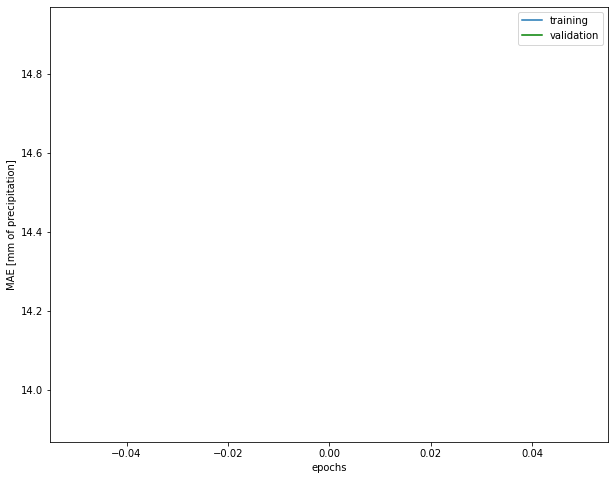

In [42]:
plt.figure(figsize=(10, 8))
plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')

Text(0, 0.5, 'Predicted 3hr precip_accumulation value')

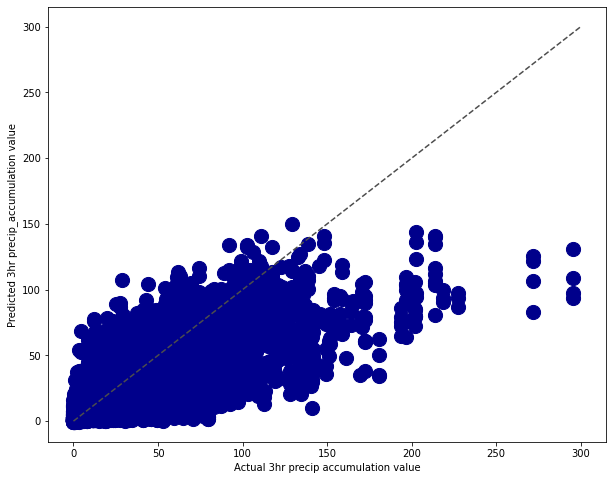

In [43]:
fig1 = plt.figure(figsize=(10, 8))
ax1 = fig1.add_subplot(1,1,1)
ax1.scatter(y_test, y_pred, s=200, c='darkblue')
ax1.plot([0, 300], [0, 300], ls="--", c=".3")
ax1.set_xlabel('Actual 3hr precip accumulation value')
ax1.set_ylabel('Predicted 3hr precip_accumulation value')

In [44]:
prd_run.log_image(name='actual_vs_pred', plot=fig1, description='predicted vs actual 3hr accumulations of rainfall')

In [64]:
with tempfile.TemporaryDirectory() as td1:
    model_save_path = pathlib.Path(td1) / prd_model_name
    model.save(model_save_path)
    prd_run.upload_folder(name=prd_model_name, path=str(model_save_path))
    prd_run.register_model(prd_model_name, prd_model_name + '/')


INFO:tensorflow:Assets written to: /tmp/tmpu12z5a_f/pipeline_demo_20220414/assets


In [65]:
prd_run.complete()

## Control member only plots

In [66]:
prd_run

Experiment,Id,Type,Status,Details Page,Docs Page
prd_mlops_test,41b6e578-7a3d-4e39-aa93-d6fb3378cf84,,Running,Link to Azure Machine Learning studio,Link to Documentation


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.title('control member only')
plt.show()

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')
plt.gca().plot([0, 300], [0, 300], ls="--", c=".3")

plt.xlabel('Actual 3hr precip accumulation value')
plt.ylabel('Predicted 3hr precip_accumulation value')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
error = mean_absolute_error(y_test, y_pred)
print(f'MAE: {error:.3f}')

rsqrd = r2_score(y_test, y_pred)
print(f'R-squared score: {rsqrd:.3f}')

In [ ]:
plt.figure(figsize=(10, 8))
plt.hist(y_test, alpha=0.5, bins=25, label='Actual')
plt.hist(y_pred, alpha=0.5, bins=25, label='Predicted')
plt.legend()
plt.show()